Using data from 304 days
To predict 170 days
Using data from 161 days
To predict 111 days

Epoch: 0, loss:81005672.0000,  mae:2581.5256,  mse:81005672.0000,  val_loss:1652752.2500,  val_mae:735.7847,  val_mse:1652752.2500,  
..................................................

Total Sales Actual: 58535.0
Total Sales Predicted: 55964.0
Individual R2 score: 0.48927404071714764 
Individual Mean Absolute Error: 838.2897649358935


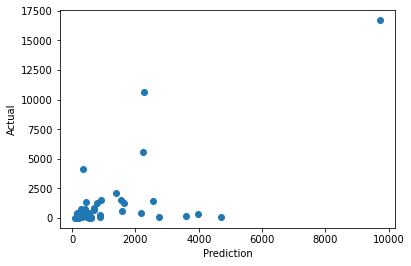

In [49]:
import pandas as pd
import numpy as np
from datetime import datetime

import psycopg2 as pg
import pandas.io.sql as psql

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

connection = pg.connect("host=localhost dbname=order_data user=postgres password=gmuonline123")
sql = "SELECT i.store_data_order_id AS InvoiceNo, sum(i.quantity_shipped) AS quantity, i.created_at AS InvoiceDate, sum(i.price_excl) as UnitPrice, sum(i.cost_price_excl) as CostPrice, o.external_customer_number AS CustomerID FROM store_data_order_items i INNER JOIN store_data_orders o ON o.store_data_order_id = i.store_data_order_id group by o.external_customer_number, i.created_at, i.store_data_order_id having o.external_customer_number is not null AND sum(i.price_excl) > 0 AND sum(i.cost_price_excl) > 0 AND sum(i.quantity_shipped) > 0 AND i.store_data_order_id is not null"
data = psql.read_sql(sql, connection)
data['invoicedate'] = pd.to_datetime(data.invoicedate, format = '%d/%m/%Y %H:%M')
data['date'] = pd.to_datetime(data.invoicedate.dt.date)
data['time'] = data.invoicedate.dt.time
data['hour'] = data['time'].apply(lambda x: x.hour)
data['weekend'] = data['date'].apply(lambda x: x.weekday() in [5, 6])
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)
data['revenue'] = data['quantity'] * data['unitprice']
def get_features(data, feature_start, feature_end, target_start, target_end):
    """
    Function that outputs the features and targets on the user-level.
    Inputs:
        * data - a dataframe with raw data
        * feature_start - a string start date of feature period
        * feature_end - a  string end date of feature period
        * target_start - a  string start date of target period
        * target_end - a  string end date of target period
    """
    features_data = data.loc[(data.date >= feature_start) & (data.date <= feature_end), :]
    print(f'Using data from {(pd.to_datetime(feature_end) - pd.to_datetime(feature_start)).days} days')
    print(f'To predict {(pd.to_datetime(target_end) - pd.to_datetime(target_start)).days} days')

    total_rev = features_data.groupby('customerid')['revenue'].sum().rename('total_revenue')
    recency = (features_data.groupby('customerid')['date'].max() - features_data.groupby('customerid')['date'].min()).apply(lambda x: x.days).rename('recency')
    frequency = features_data.groupby('customerid')['invoiceno'].count().rename('frequency')
    t = features_data.groupby('customerid')['date'].min().apply(lambda x: (datetime(2019, 11, 1) - x).days).rename('t')
    time_between = (t / frequency).rename('time_between')
    avg_basket_value = (total_rev / frequency).rename('avg_basket_value')
    avg_basket_size = (features_data.groupby('customerid')['quantity'].sum() / frequency).rename('avg_basket_Size')
    hour = features_data.groupby('customerid')['hour'].median().rename('purchase_hour_med')
    dow = features_data.groupby('customerid')['dayofweek'].median().rename('purchase_dow_med')
    weekend =  features_data.groupby('customerid')['weekend'].mean().rename('purchase_weekend_prop')
    train_data = pd.DataFrame(index = data.index)
    train_data = train_data.join([total_rev, recency, frequency, t, time_between, avg_basket_value, avg_basket_size, hour, dow, weekend], how = 'inner')
    train_data = train_data.fillna(0)
    target_data = data.loc[(data.date >= target_start) & (data.date <= target_end), :]
    target_rev = target_data.groupby(['customerid'])['revenue'].sum().rename('target_rev')
    train_data = train_data.join(target_rev, how='inner').fillna(0)
    return train_data.iloc[:, :-1], train_data.iloc[:, -1] #X and Y

X_train, y_train = get_features(data, '2019-01-01', '2019-11-01', '2019-11-02', '2020-04-20')
X_test, y_test = get_features(data, '2019-04-02', '2019-09-10', '2019-09-11', '2019-12-31')
def build_model():
    model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(X_train.columns), ]),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae', 'mse'])

    return model

early_stop = keras.callbacks.EarlyStopping(monitor='val_mse', patience=50)

model = build_model()
early_history = model.fit(X_train, y_train,
                    epochs=50, validation_split = 0.2, verbose=0,
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

def evaluate(actual, sales_prediction):
    print("\n")
    print(f"Total Sales Actual: {np.round(actual.sum())}")
    print(f"Total Sales Predicted: {np.round(sales_prediction.sum())}")
    print(f"Individual R2 score: {r2_score(actual, sales_prediction)} ")
    print(f"Individual Mean Absolute Error: {mean_absolute_error(actual, sales_prediction)}")
    plt.scatter(sales_prediction, actual)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.show()

dnn_preds = model.predict(X_test).ravel()
evaluate(y_test, dnn_preds)
